[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/rkarmaka/Global-BioImaging-Image-Data-2025-Course---India/blob/main/course_material/06182025_day3/07_feature_extraction_handson.ipynb)

# Feature extraction (intensity, morphological and spatial features)

---

## Introduction to Feature Extraction

Feature extraction is the process of computing quantitative descriptors from image data that help capture relevant patterns, structures, or biological signals. In the context of microscopy, these features represent properties of cells, tissues, organelles, or other biological structures. Feature extraction bridges raw image data with biological insight, enabling classification, clustering, and statistical analysis.

There are three broad types of features typically extracted:
- **Intensity features:** Related to the pixel brightness distribution.
- **Morphological features:** Describe shape and size.
- **Spatial features:** Capture location and relationship between structures.

These features can be computed on entire images or, more commonly, on segmented regions of interest (ROIs), such as individual nuclei or cells.

---
## Intensity Features
### Concept and Importance
Intensity features summarize the distribution of grayscale or fluorescence values within an object or ROI. These features are sensitive to signal strength and can reflect biological activity like protein expression, DNA content, or mitochondrial potential.

They are generally derived from the pixel intensity values inside the segmented region (mask). Typical intensity features include:

- **Mean intensity:** The average value of pixels.
- **Median intensity:** The central tendency that is robust to outliers.
- **Minimum and maximum:** Identify the brightest and darkest pixels.
- **Standard deviation:** A measure of contrast or texture variation.
- **Integrated intensity:** Sum of all pixel values, useful for quantifying total signal.
- **Percentiles (e.g., 25th, 75th):** For understanding the distribution spread.

These are simple yet powerful features and often correlate with molecular content in fluorescence microscopy.


### Practical Notes
Ensure intensity normalization (e.g., background subtraction, illumination correction) before feature extraction, especially when comparing across fields of view or slides.

### Coding Exercise

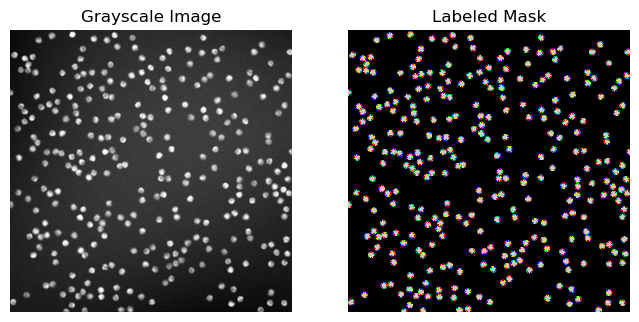

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import regionprops, label

# Load grayscale image (e.g., nuclei)
image = imread("data/1GRAY.tif")

# Load corresponding label mask (should be labeled; each object has unique integer)
mask = imread("data/1.tif")

# If the mask is binary, label it
if mask.max() == 1:
    mask = label(mask)

# Visualize
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='nipy_spectral')
plt.title('Labeled Mask')
plt.axis('off')
plt.show()


In [2]:
from skimage.measure import regionprops_table
import pandas as pd

# Extract intensity features for each labeled region
labeled_mask = label(mask)
props_intensity = regionprops_table(labeled_mask, intensity_image=image,
    properties=['label', 'mean_intensity', 'max_intensity', 'min_intensity', 
                'intensity_std', 'area'])

# Convert to DataFrame for easy handling
df_intensity = pd.DataFrame(props_intensity)
df_intensity.head()


AttributeError: '<class 'skimage.measure._regionprops.RegionProperties'>' object has no attribute 'intensity_std'

---
## Morphological Features
### What Are Morphological Features?
Morphological features describe the shape, size, and geometric properties of objects in the image. These features are crucial for characterizing phenotypic differences such as cell elongation, roundness, or area differences in cancer vs. healthy tissue.

Common morphological features include:
- Area: Number of pixels in the object. Important for size estimation.
- Perimeter: Length of the object’s boundary.
- Major and Minor Axis Lengths: From fitted ellipses; reflect elongation.
- Eccentricity: A measure of how elongated an object is, ranging from 0 (circle) to 1 (line).
- Circularity or Roundness: Often computed as $\frac{4π⋅Area}{Perimeter^{2}}$; closer to 1 means more circular.
- Solidity: Area / Convex Area; indicates irregularity of shape.
- Extent: Ratio of object area to bounding box area.
- Orientation: The angle of the object’s major axis with respect to the x-axis.

These features provide powerful, interpretable descriptors that help distinguish object types and cell states.

### Biological Interpretations
- Large area might suggest hypertrophy or multinucleation.
- High eccentricity may indicate elongated cells, as seen in fibroblasts or migrating cells.
- Low solidity could indicate fragmented or irregular nuclei.

### Considerations in Practice
Morphological features are sensitive to segmentation quality. Debris, artifacts, or touching objects can lead to incorrect measurements. Always inspect a few random samples visually to validate your results.

### Coding Exercise


In [12]:
# Extract morphological (shape) features
props_shape = regionprops_table(labeled_mask, 
    properties=['label', 'area', 'perimeter', 'eccentricity', 
                'solidity', 'orientation', 'major_axis_length', 
                'minor_axis_length'])

df_shape = pd.DataFrame(props_shape)
df_shape.head()


,label,area,perimeter,eccentricity,solidity,orientation,major_axis_length,minor_axis_length
0,1,321.0,64.870058,0.387213,0.963964,-1.050878,21.109467,19.462723
1,2,298.0,61.698485,0.364226,0.967532,1.149075,20.215977,18.827355
2,3,336.0,66.526912,0.193975,0.957265,-0.832187,20.956556,20.558515
3,4,313.0,63.941125,0.346266,0.960123,0.586113,20.646999,19.369701
4,5,306.0,62.526912,0.460456,0.971429,-0.934755,20.967487,18.612470


---

## Spatial Features
### Concept and Applications
Spatial features deal with the position of objects in space and their relation to one another. These are essential in understanding cell-cell interaction, tissue organization, or subcellular localization patterns.

There are two subcategories:

**A. Absolute Spatial Features**
- These relate to an object's location in the image:
- Centroid (x, y coordinates): Geometric center of the object.
- Distance from image center or landmark: Useful in studying gradients or symmetry.
- Radial position: Especially relevant in organoids or spheroids.

**B. Relative Spatial Features**
These features describe the relationship between objects:
- Nearest neighbor distance: Measures crowding or isolation.
- Cluster metrics: Such as number of neighbors within a certain radius.
- Voronoi-based area: Captures local density or influence zone.
- Distance to boundary: E.g., for cell polarization or proximity to blood vessels.

### Biological Use Cases
- In cancer pathology, tightly packed nuclei may indicate malignancy.
- In immunofluorescence, co-localization of proteins can be quantified via centroid distances.
- In developmental biology, cell positions can help track lineage or spatial fate.

### Challenges and Tips
- Requires accurate centroid or boundary detection.
- Use consistent coordinate systems (beware of image cropping).
- Often needs domain knowledge to define what constitutes "nearness" or "interaction".

### Coding Exercise

In [15]:
from scipy.spatial import distance_matrix

# Use regionprops to get centroids
labeled_mask = label(mask)
regions = regionprops(labeled_mask)

# Get centroids
centroids = np.array([r.centroid for r in regions])
labels = np.array([r.label for r in regions])

# Create a distance matrix between all centroids
dist_matrix = distance_matrix(centroids, centroids)

# For each object, find distance to nearest neighbor (excluding itself)
nearest_neighbor_distance = []
for i in range(len(centroids)):
    dists = dist_matrix[i]
    dists[i] = np.inf  # ignore self-distance
    nearest_neighbor_distance.append(np.min(dists))

# Add to DataFrame
df_spatial = pd.DataFrame({
    'label': labels,
    'centroid_x': centroids[:, 1],
    'centroid_y': centroids[:, 0],
    'nearest_neighbor_dist': nearest_neighbor_distance
})

df_spatial.head()

,label,centroid_x,centroid_y,nearest_neighbor_dist
0,1,209.950156,14.691589,60.154079
1,2,352.359060,17.288591,30.511393
2,3,140.693452,18.750000,46.712679
3,4,650.549521,25.757188,51.666064
4,5,412.366013,26.186275,35.191155


---
## Final Thoughts and Recommendations
Feature extraction is a critical step in turning image data into knowledge. It's essential that microscopists understand what these features mean biologically, how they're computed, and how their reliability depends on proper segmentation and preprocessing.

Tips for robust feature extraction:
- Always visualize features (e.g., overlay eccentricity values on masks).
- Perform sanity checks (e.g., histogram of area should not have absurd values).
- Combine multiple features for richer biological interpretation.
- Use open-source tools like scikit-image, OpenCV, cellpose, and napari plugins for efficient workflows.

In future workflows, these features can be fed into machine learning models, statistical pipelines, or interactive dashboards for hypothesis generation or automated classification.